In [35]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [36]:
## Helper Function

def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def create_sequences(data, lookback_window):
    X = []
    y = []
    for i in range(lookback_window, len(data)):
        X.append(data[i-lookback_window:i])  
        y.append(data[i, 0])
    return np.array(X), np.array(y)

## Feature Engineering

In [37]:
### I will just base my model on BTC dataframe since it is the most complete and there is a lead/lag rs with BTC and other tokens

df_btc = pd.read_csv("./Top 100 Crypto Coins/bitcoin.csv")
df_btc['Close Lag'] = df_btc['Close'].shift(1)

### Performing log returns
df_btc['Log Return'] = np.log(df_btc['Close'] / df_btc['Close Lag'])
df_btc.set_index('Date', inplace=True)

### Calculate rolling window of 30 days first
df_btc['Average 30 days log'] = df_btc['Log Return'].rolling(30).mean()
df_btc['Difference in Returns'] = (df_btc['Log Return'] - df_btc['Average 30 days log']) ** 2
df_btc['Parameter'] = df_btc['Difference in Returns'].rolling(30).sum() 
df_btc['Annualized Volatility 30 Days'] = np.sqrt(365) * np.sqrt(1/30 * df_btc['Parameter'])

df_btc.drop(columns=["Average 30 days log", "Difference in Returns", "Parameter"], inplace=True)
df_btc.dropna(inplace=True)

In [38]:
df_btc.index = pd.to_datetime(df_btc.index)
df_btc_reduced = df_btc[(df_btc.index >= pd.to_datetime("2020-09-01"))]

## BTC volatility to be included in exploratory variable -- now we test on Token X (ETH)

In [39]:
df_eth = pd.read_csv("./Top 100 Crypto Coins/ethereum.csv")
df_eth['Close Lag'] = df_eth['Close'].shift(1)

### Performing log returns
df_eth['Log Return'] = np.log(df_eth['Close'] / df_eth['Close Lag'])
df_eth.set_index('Date', inplace=True)

### Calculate rolling window of 30 days first
df_eth['Average 30 days log'] = df_eth['Log Return'].rolling(30).mean()
df_eth['Difference in Returns'] = (df_eth['Log Return'] - df_eth['Average 30 days log']) ** 2
df_eth['Parameter'] = df_eth['Difference in Returns'].rolling(30).sum() 
df_eth['Annualized Volatility 30 Days'] = np.sqrt(365) * np.sqrt(1/30 * df_eth['Parameter']) ## This is the variable that we want to test
df_eth['Log Trading Range'] = np.log(df_eth['High']) - np.log(df_eth['Low'])
df_eth['Log_Volume_Change'] = np.log(df_eth['Volume']) - np.log(df_eth['Volume'].shift(1))
df_eth['RSI'] = calculate_rsi(df_eth['Close'], window=7)

df_eth.dropna(inplace=True)

## Selecting the previous bullrun as a time frame to train/test our model

In [40]:
df_eth.index = pd.to_datetime(df_eth.index)
df_eth_reduced = df_eth[(df_eth.index >= pd.to_datetime("2020-09-01"))]
df_eth_reduced.reset_index(inplace=True)
train_df = df_eth_reduced.iloc[:int(len(df_eth_reduced) * 0.8)]
test_df = df_eth_reduced.iloc[int(len(df_eth_reduced) * 0.8):]
train_df.set_index("Date", inplace=True)
test_df.set_index("Date", inplace=True)

## We are using a hybrid GARCH + LSTM model.

### Therefore, the objective involves inputing the parameters of GARCH as inputs to the LSTM model

In [41]:
log_returns = train_df['Log Return']
window_size = 30 ## Make use of a window size of 30. Opposed to 22 since crypto doesn't have non trading days

omega_list = []
alpha_list = []
beta_list = []

for i in range(window_size, len(log_returns)):
    window_data = log_returns[i-window_size:i]
    garch_model = arch_model(window_data, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')

    omega = garch_fit.params['omega']
    alpha = garch_fit.params['alpha[1]']
    beta = garch_fit.params['beta[1]']
        
    omega_list.append(omega)
    alpha_list.append(alpha)
    beta_list.append(beta)

garch_params_df = pd.DataFrame({
    'omega': omega_list,
    'alpha': alpha_list,
    'beta': beta_list,
}, index=log_returns.index[window_size:])

### We also need to include exploratory variables that will also serve as inputs to the model

In [42]:
omega_list_g = omega_list            
alpha_list_g = alpha_list           
beta_list_g = beta_list

combined_features = np.column_stack((
    train_df['Annualized Volatility 30 Days'][window_size:], 
    train_df['Log Return'][window_size:],
    train_df['RSI'][window_size:],
    train_df['Close'].ewm(span=7).mean()[window_size:],
    train_df['Close'].rolling(window=14).mean()[window_size:],
    train_df['Close'][window_size:],
    train_df['Annualized Volatility 30 Days'].ewm(span=7).mean()[window_size:],
    df_btc_reduced['Annualized Volatility 30 Days'][window_size:train_df.shape[0]], ### Fixed parameter to account for leader BTC's volatility
    omega_list_g,
    alpha_list_g,
    beta_list_g,
))

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_features)

In [43]:
lookback_window = 30

def create_sequences(data, lookback_window):
    X = []
    y = []
    for i in range(lookback_window, len(data)):
        X.append(data[i-lookback_window:i])  
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_features, lookback_window)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

## Building the LSTM Model

In [44]:
model = Sequential()

model.add(LSTM(units=10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

model.add(LSTM(units=4, return_sequences=True))
model.add(Dropout(0.8)) 

model.add(LSTM(units=2))
model.add(Dropout(0.8)) 

model.add(Dense(units=5, activation='relu'))
model.add(Dense(units=1))

optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 10)         │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 4)          │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 2)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,197 (4.68 KB)

 Trainable params: 1,197 (4.68 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.fit(X_train, y_train, epochs=150, batch_size=32)

Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1567
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1191
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0941
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0740
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0675
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0616
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0586
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0465
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0469
Epoch 10/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0452
Epoch 11/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0431
Epoch 12/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0439
Epoch 13/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0444
Epoch 14/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0397
Epoch 15/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - lo

## Perform prediction based on our test dataframe

### We have to change our test_df into sequences

In [ ]:
### I want to make the prediction continuous instead of having a disrupted period of 30 days due to window size

train_end_extension = train_df[-window_size:]
extended_test_df = pd.concat([train_end_extension, test_df])
log_returns_test = extended_test_df['Log Return']
window_size = 30

omega_list_test = []
alpha_list_test = []
beta_list_test = []

for i in range(window_size, len(log_returns_test)):
    window_data = log_returns_test[i-window_size:i]
    garch_model = arch_model(window_data, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')

    omega = garch_fit.params['omega']
    alpha = garch_fit.params['alpha[1]']
    beta = garch_fit.params['beta[1]']
        
    omega_list_test.append(omega)
    alpha_list_test.append(alpha)
    beta_list_test.append(beta)

garch_params_df = pd.DataFrame({
    'omega': omega_list_test,
    'alpha': alpha_list_test,
    'beta': beta_list_test,
}, index=log_returns_test.index[window_size:])

In [47]:
omega_list_g = omega_list_test            
alpha_list_g = alpha_list_test       
beta_list_g = beta_list_test

combined_features_test = np.column_stack((
    extended_test_df['Annualized Volatility 30 Days'][window_size:], 
    extended_test_df['Log Return'][window_size:],
    extended_test_df['RSI'][window_size:],
    extended_test_df['Close'].ewm(span=7).mean()[window_size:],
    extended_test_df['Close'].rolling(window=14).mean()[window_size:],
    extended_test_df['Close'][window_size:],
    extended_test_df['Annualized Volatility 30 Days'].ewm(span=7).mean()[window_size:],
    df_btc_reduced['Annualized Volatility 30 Days'][train_df.shape[0]: df_eth_reduced.shape[0] + 1],
    omega_list_g,
    alpha_list_g,
    beta_list_g,
))

scaler = MinMaxScaler()
scaled_features_test = scaler.fit_transform(combined_features_test)

In [48]:
lookback_window = 30

def create_sequences(data, lookback_window):
    X = []
    y = []
    for i in range(lookback_window, len(data)):
        X.append(data[i-lookback_window:i])  
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_test, y_test = create_sequences(scaled_features_test, lookback_window)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [49]:
# Make predictions on the test set and plot the actual vs predicted
predictions_test = model.predict(X_test)
mse = mean_squared_error(y_test, predictions_test)
print(f"Mean Squared Error (MSE): {mse}")

1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 972ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x15339f740> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step
Mean Squared Error (MSE): 0.07828878361045115


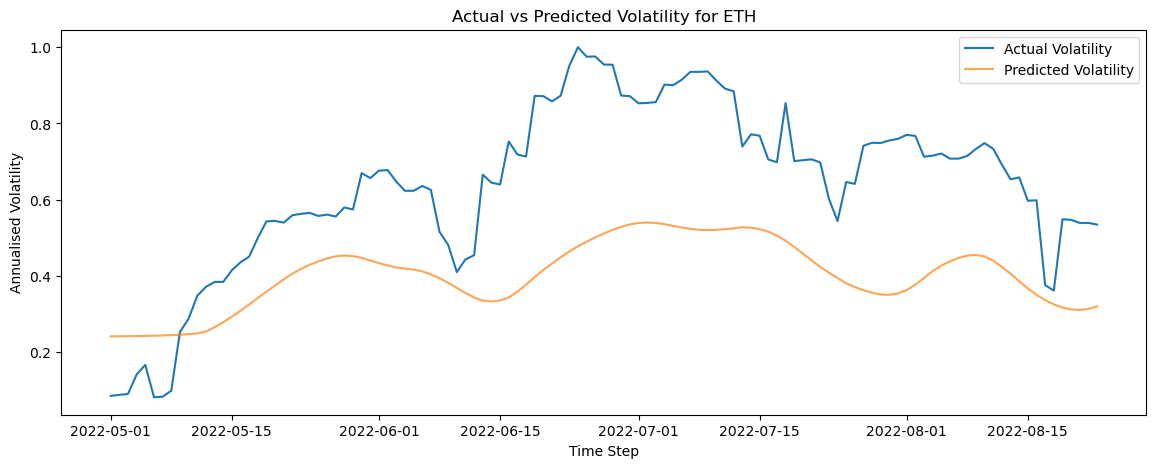

In [50]:
plt.figure(figsize=(14, 5))
plt.plot(test_df.iloc[window_size:].index, y_test, label='Actual Volatility')
plt.plot(test_df.iloc[window_size:].index, predictions_test, label='Predicted Volatility', alpha=0.7)
plt.title('Actual vs Predicted Volatility for ETH')
plt.xlabel('Time Step')
plt.ylabel('Annualised Volatility')
plt.legend()
plt.show()